Epoch 1/50
130/130 [==============================] - 600s 5s/step - loss: 1.7856 - accuracy: 0.2913 - val_loss: 1.6085 - val_accuracy: 0.3744
Epoch 2/50
130/130 [==============================] - 693s 5s/step - loss: 1.5779 - accuracy: 0.3805 - val_loss: 1.4993 - val_accuracy: 0.4000
Epoch 3/50
130/130 [==============================] - 732s 6s/step - loss: 1.5089 - accuracy: 0.4171 - val_loss: 1.4838 - val_accuracy: 0.4288
Epoch 4/50
130/130 [==============================] - 708s 5s/step - loss: 1.4613 - accuracy: 0.4315 - val_loss: 1.4256 - val_accuracy: 0.4519
Epoch 5/50
130/130 [==============================] - 689s 5s/step - loss: 1.4421 - accuracy: 0.4507 - val_loss: 1.3862 - val_accuracy: 0.4787
Epoch 6/50
130/130 [==============================] - 684s 5s/step - loss: 1.3843 - accuracy: 0.4668 - val_loss: 1.3875 - val_accuracy: 0.4881
Epoch 7/50
130/130 [==============================] - 674s 5s/step - loss: 1.3520 - accuracy: 0.4887 - val_loss: 1.3770 - val_accuracy: 0.4731

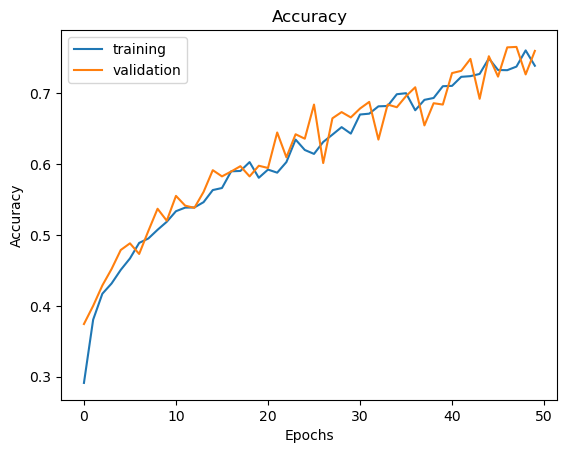

ValueError: in user code:

    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1972, in test_function  *
        return step_function(self, iterator)
    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1956, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1944, in run_step  **
        outputs = model.test_step(data)
    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1852, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 7) are incompatible


In [2]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  # train-test split을 위해 추가
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# TensorFlow GPU 메모리 동적 관리 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# ResNet-50 모델 불러오기 및 커스터마이징
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 862, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# 최종 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# ResNet-50 기본 모델 레이어를 고정하여 학습되지 않도록 함
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 데이터셋 및 레이블 생성 함수
def generate_data(data_dir, class_labels, batch_size, is_training=True):
    while True:
        batch_X = []
        batch_labels = []
        data_to_use = os.listdir(data_dir)
        
        if is_training:
            data_to_use = train_test_split(data_to_use, test_size=0.2, random_state=42)[0]
        else:
            data_to_use = train_test_split(data_to_use, test_size=0.2, random_state=42)[1]
        
        for _ in range(batch_size):
            label_idx = np.random.randint(num_classes)
            label = class_labels[label_idx]
            class_dir = os.path.join(data_dir, label)
            
            # 수정된 부분: class_dir 내에 있는 파일들을 이용해 무작위로 파일을 선택합니다.
            filename = np.random.choice(os.listdir(class_dir))
            file_path = os.path.join(class_dir, filename)

            y, sr = librosa.load(file_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels

# 모델 학습 및 validation 데이터 사용
batch_size = 32
steps_per_epoch = 150
epochs = 50

# 훈련 데이터셋 생성 함수
train_data_generator = generate_data(data_dir, class_labels, batch_size, is_training=True)

# 테스트 데이터셋 생성 함수
test_data_generator = generate_data(data_dir, class_labels, batch_size, is_training=False)

# 모델 학습
history = model.fit(
    train_data_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=test_data_generator,
    validation_steps=50)

# 학습 결과 시각화
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')  # 검증 데이터 정확도 추가
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()